In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesGeometric3Multispectral.nc')

# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, 3) # 3 means open boundary in both dimensions
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
solvers[.66].medium['cloud'].reff.data[np.where(carved_volume.mask.data == 0)] = 0

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}

mie_mono_tables = OrderedDict()
for wavelength in sensors.get_unique_solvers():
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
size_distribution_function = at3d.size_distribution.gamma
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    maxnphase=1e9,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

# We are using the ground_truth rte_grid.
#dataset = dataset.reset_coords(['reff'], drop=True)

In [2]:
def train_density(solvers_reconstruct_reff, i):
    uncertainty_density = at3d.uncertainties.NullUncertainty('L2',i*1e10) #replaces original uncertainty
    sensors.add_uncertainty_model('MSPI', uncertainty_density)

    data_with_reff = solvers_reconstruct_reff[.66].medium['cloud'].drop_vars("density")

    micro_grid_with_reff = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, data_with_reff
    )

    relative_scaling_density = 1
    unknown_scatterer_density = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(micro_grid_with_reff,
        density=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].density.data), relative_scaling_density * 1.0/np.std(solvers[.66].medium['cloud'].density.data)), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        )
    )

    # now we form state_gen which updates the solvers with an input_state.
    solvers_reconstruct_density = at3d.containers.SolversDict()

    state_gen_density = at3d.medium.StateGenerator(solvers_reconstruct_density,
                                            unknown_scatterer_density, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)

    min_bounds_density, max_bounds_density = state_gen_density.transform_bounds()
    forward_sensors_density = sensors.make_forward_sensors()

    initial_gridded_density = solvers_reconstruct_reff[.66].medium['cloud'].density.data
    initial_1d_density = state_gen_density._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_density)
    x2 = state_gen_density._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_density)

    objective_function_density = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct_density, forward_sensors_density, unknown_scatterer_density, state_gen_density,
    state_gen_density.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds_density, max_bounds=max_bounds_density)


    def plot_density(optimizer):
        fig, axs = py.subplots(1, 2, figsize=(12, 6))  # Create a figure with subplots side by side
        # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
        #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
        # axs[0].plot([0,130],[0,130])
        axs[1].plot(solvers_reconstruct_density[0.66].medium['cloud'].density.data.ravel(), 
                solvers[0.66].medium['cloud'].density.data.ravel(),'x')
        axs[1].plot([0,2],[0,2])
        axs[0].plot(solvers_reconstruct_density[0.66].medium['cloud'].reff.data.ravel(), 
                solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
        axs[0].plot([0,20],[0,20])
        #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
                #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
        #axs[3].plot([0,30],[0,30])
        # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
        #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        #         uncertainty_kwargs={'add_noise': False})()
        # grads = optimizer_reff.objective(optimizer_reff._state)[1]
        # print(grads.shape)
        # print(grads.mean())
        # print(grads.std())
        py.show()
        return {'None': None}
    callback_density = at3d.callback.CallbackFn(plot_density)

    import warnings
    optimizer_density = at3d.optimize.Optimizer(objective_function_density,callback_fn=callback_density, options={'maxiter': 100, 'maxls': 10, 'disp': True})
    warnings.filterwarnings('ignore')
    optimizer_density._options['maxiter'] = 1
    result_density = optimizer_density.minimize(x2)
    return solvers_reconstruct_density

In [3]:
def train_reff(solvers_reconstruct_density, i):
    uncertainty_reff = at3d.uncertainties.NullUncertainty('L2',i*1e10) #replaces original uncertainty
    sensors.add_uncertainty_model('MSPI', uncertainty_reff)

    data_with_extinction = solvers_reconstruct_density[.66].medium['cloud'].drop_vars("reff")

    micro_grid_with_extinction = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, data_with_extinction
    )

    relative_scaling_reff = 1
    unknown_scatterer_reff = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(micro_grid_with_extinction,
        reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
        )
    )

    # now we form state_gen which updates the solvers with an input_state.
    solvers_reconstruct_reff = at3d.containers.SolversDict()

    state_gen_reff = at3d.medium.StateGenerator(solvers_reconstruct_reff,
                                            unknown_scatterer_reff, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)

    min_bounds_reff, max_bounds_reff = state_gen_reff.transform_bounds()
    forward_sensors_reff = sensors.make_forward_sensors()

    regularization = at3d.regularization.Tikhonov(state_gen_reff, "cloud", "reff", 12.0)

    initial_gridded_reff = solvers_reconstruct_density[.66].medium['cloud'].reff.data
    initial_1d_reff = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x1 = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)

    objective_function_reff = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct_reff, forward_sensors_reff, unknown_scatterer_reff, state_gen_reff,
    state_gen_reff.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds_reff, max_bounds=max_bounds_reff)


    def plot_reff(optimizer):
        fig, axs = py.subplots(1, 2, figsize=(12, 6))  # Create a figure with subplots side by side
        # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
        #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
        # axs[0].plot([0,130],[0,130])
        axs[1].plot(solvers_reconstruct_reff[0.66].medium['cloud'].density.data.ravel(), 
                solvers[0.66].medium['cloud'].density.data.ravel(),'x')
        axs[1].plot([0,2],[0,2])
        axs[0].plot(solvers_reconstruct_reff[0.66].medium['cloud'].reff.data.ravel(), 
                solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
        axs[0].plot([0,20],[0,20])
        #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
                #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
        #axs[3].plot([0,30],[0,30])
        # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
        #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        #         uncertainty_kwargs={'add_noise': False})()
        # grads = optimizer_reff.objective(optimizer_reff._state)[1]
        # print(grads.shape)
        # print(grads.mean())
        # print(grads.std())
        py.show()
        return {'None': None}
    callback_reff = at3d.callback.CallbackFn(plot_reff)

    import warnings
    optimizer_reff = at3d.optimize.Optimizer(objective_function_reff, prior_fn=regularization, callback_fn=callback_reff, options={'maxiter': 100, 'maxls': 10, 'disp': True})
    warnings.filterwarnings('ignore')
    optimizer_reff._options['maxiter'] = 1
    result_reff = optimizer_reff.minimize(x1)
    return solvers_reconstruct_reff

In [4]:
def train_reff_full(solvers_reconstruct_density, i):
    uncertainty_reff = at3d.uncertainties.NullUncertainty('L2',i*1e14) #replaces original uncertainty
    sensors.add_uncertainty_model('MSPI', uncertainty_reff)

    data_with_extinction = solvers_reconstruct_density[.66].medium['cloud'].drop_vars("reff")

    micro_grid_with_extinction = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, data_with_extinction
    )

    relative_scaling_reff = 1
    unknown_scatterer_reff = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(micro_grid_with_extinction,
        reff=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        )
    )

    # now we form state_gen which updates the solvers with an input_state.
    solvers_reconstruct_reff = at3d.containers.SolversDict()

    state_gen_reff = at3d.medium.StateGenerator(solvers_reconstruct_reff,
                                            unknown_scatterer_reff, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)

    min_bounds_reff, max_bounds_reff = state_gen_reff.transform_bounds()
    forward_sensors_reff = sensors.make_forward_sensors()

    initial_gridded_reff = solvers_reconstruct_density[.66].medium['cloud'].reff.data
    initial_1d_reff = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x1 = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)

    objective_function_reff = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct_reff, forward_sensors_reff, unknown_scatterer_reff, state_gen_reff,
    state_gen_reff.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': True},
    min_bounds=min_bounds_reff, max_bounds=max_bounds_reff)


    def plot_reff(optimizer):
        fig, axs = py.subplots(1, 2, figsize=(12, 6))  # Create a figure with subplots side by side
        # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
        #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
        # axs[0].plot([0,130],[0,130])
        axs[1].plot(solvers_reconstruct_reff[0.66].medium['cloud'].density.data.ravel(), 
                solvers[0.66].medium['cloud'].density.data.ravel(),'x')
        axs[1].plot([0,2],[0,2])
        axs[0].plot(solvers_reconstruct_reff[0.66].medium['cloud'].reff.data.ravel(), 
                solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
        axs[0].plot([0,20],[0,20])
        #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
                #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
        #axs[3].plot([0,30],[0,30])
        # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
        #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        #         uncertainty_kwargs={'add_noise': False})()
        # grads = optimizer_reff.objective(optimizer_reff._state)[1]
        # print(grads.shape)
        # print(grads.mean())
        # print(grads.std())
        py.show()
        return {'None': None}
    callback_reff = at3d.callback.CallbackFn(plot_reff)

    import warnings
    optimizer_reff = at3d.optimize.Optimizer(objective_function_reff,callback_fn=callback_reff, options={'maxiter': 100, 'maxls': 10, 'disp': True})
    warnings.filterwarnings('ignore')
    optimizer_reff._options['maxiter'] = 1
    result_reff = optimizer_reff.minimize(x1)
    return solvers_reconstruct_reff

------ Iter 0 ------
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -4.857  0.821E-07    31968     9.00  0.035   [Radiance 2.130 micron]
 ! Iterations:      1     Final Criterion:  0.000014   [Radiance 2.130 micron]
     1  -3.328  0.131E-05    31968     9.00  0.035   [Radiance 1.240 micron]
     1  -3.973  0.628E-06    31968     9.00  0.035   [Radiance 1.640 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -6.284  0.131E-05    31968     9.00  0.035   [Radiance 1.240 micron]
 ! Iterations:      2     Final Criterion:  0.000001   [Radiance 1.240 micron]
     2  -7.327  0.628E-06    31968     9.00  0.035   [Radiance 1.640 micron]
 ! Iterations:      2     Final Criterion:  0.000000   [Radianc

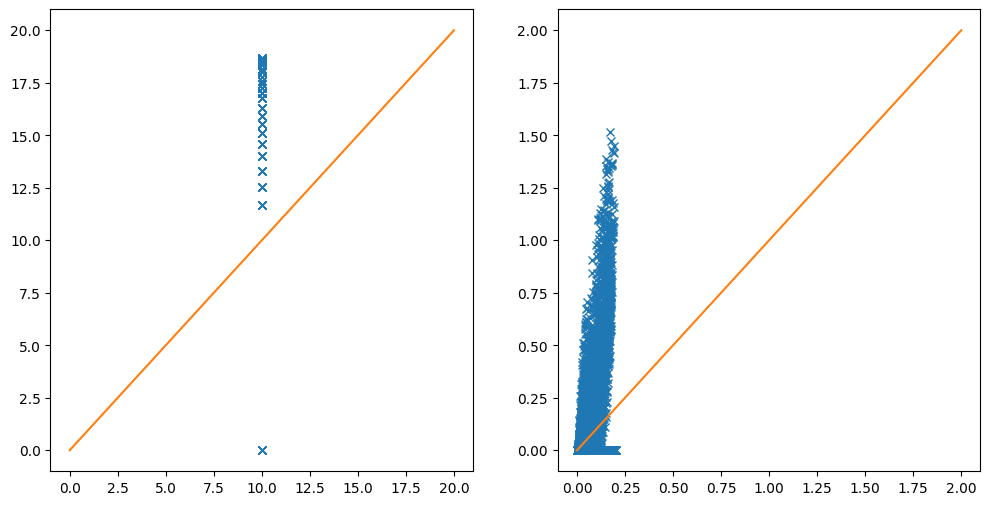


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      5      1     0     0   4.436D+00   1.449D+02
  F =   144.93816225828076     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -1.828  0.688E-02    31968   228.05  0.891   [Radiance 0.660 micron]
     1  -1.864  0.829E-02    31968   228.05  0.891

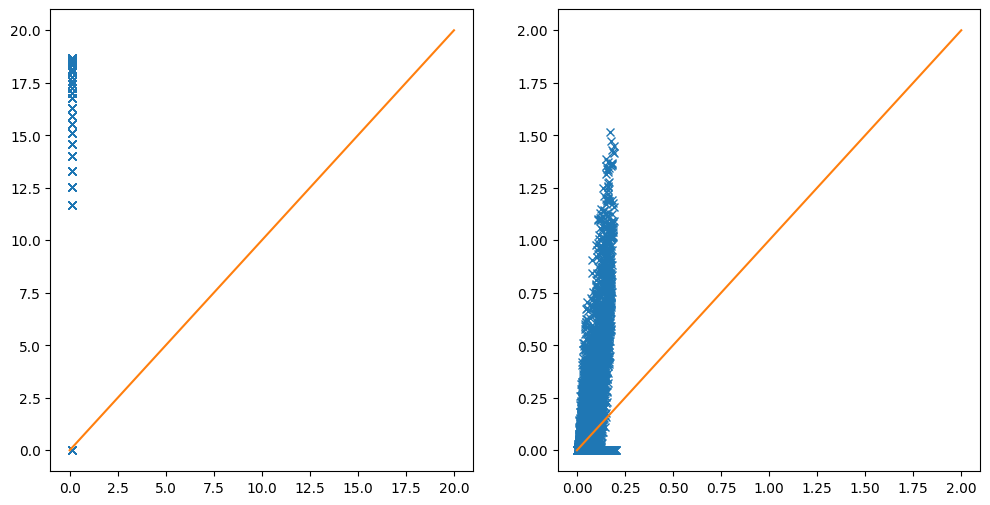

------ Iter 1 ------

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      2     27     0    27   0.000D+00   4.053D+03
  F =   4053.3412327207598     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -2.342  0.259E-03    31968   228.05  0.891   [Radiance 0.660 micron]
     1  -4.818  0.306E-05    

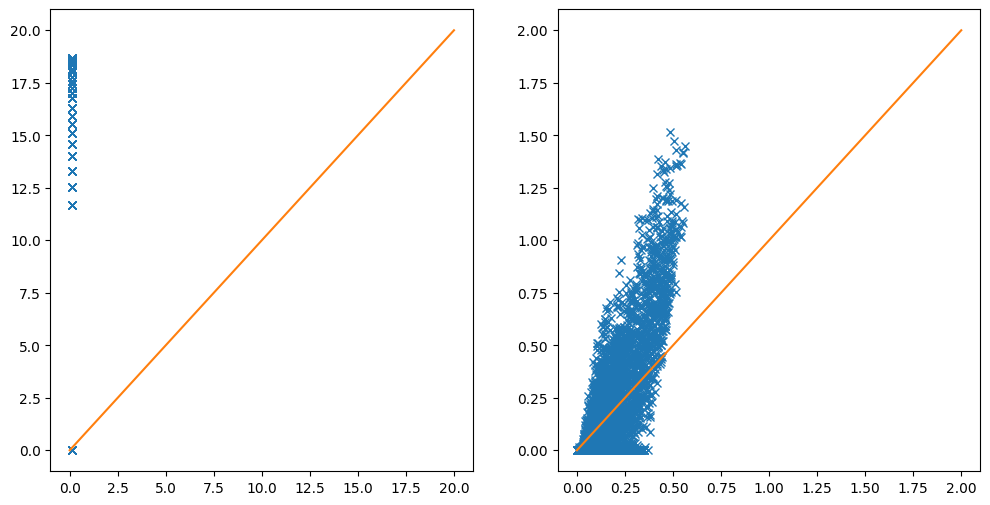


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      2   2409     0  2408   1.076D+00   4.055D+02
  F =   405.52819461117571     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -2.352  0.101E-03    31968   209.44  0.818   [Radiance 0.660 micron]
     1  -4.471  0.799E-06    31968   209.44  0.818

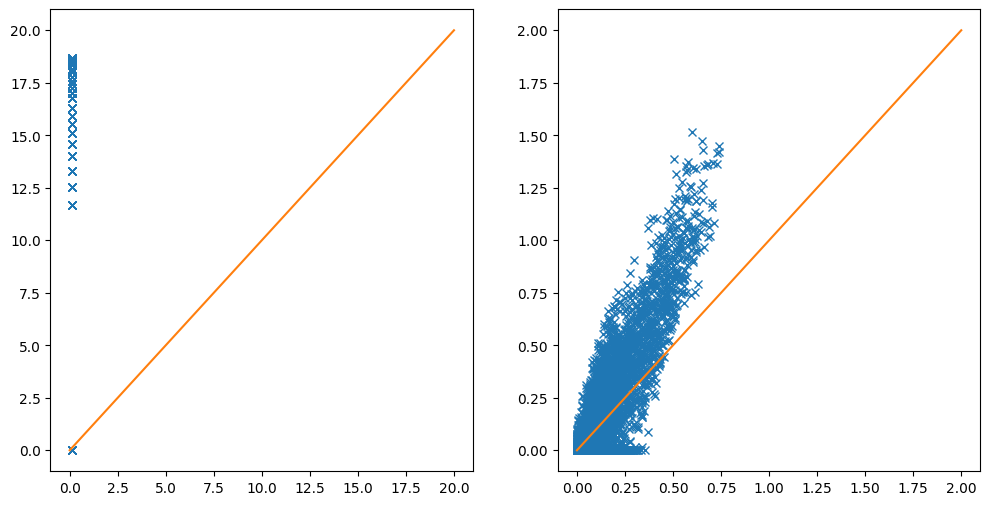


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      2  12261     0 13811   1.831D+00   5.630D+02
  F =   562.98460575616218     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -2.276  0.490E-03    31968   121.34  0.474   [Radiance 0.660 micron]
     1  -4.539  0.289E-05    31968   121.34  0.474

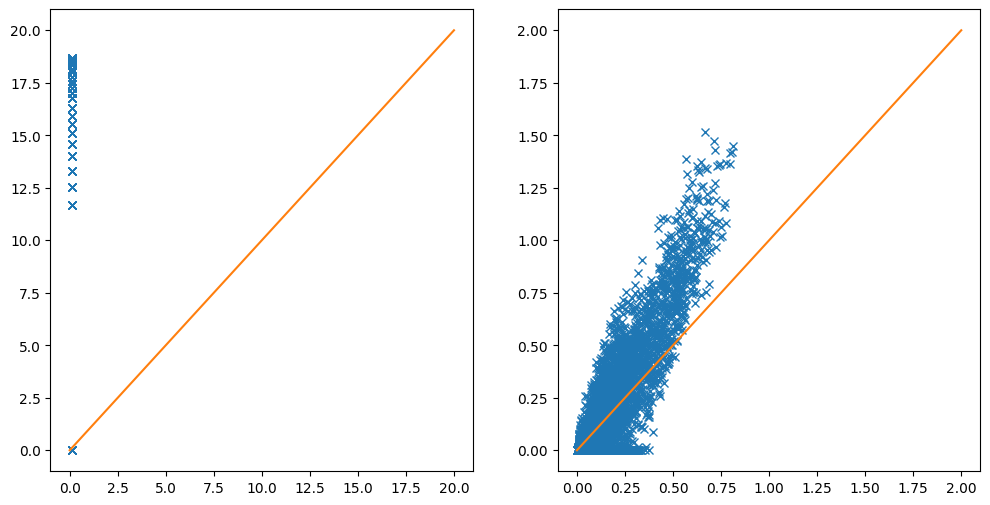


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      4    229     0   606   1.727D+00   7.468D+02
  F =   746.75328006687914     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -2.297  0.497E-03    31968   225.12  0.879   [Radiance 0.660 micron]
     1  -4.460  0.318E-05    31968   225.12  0.879

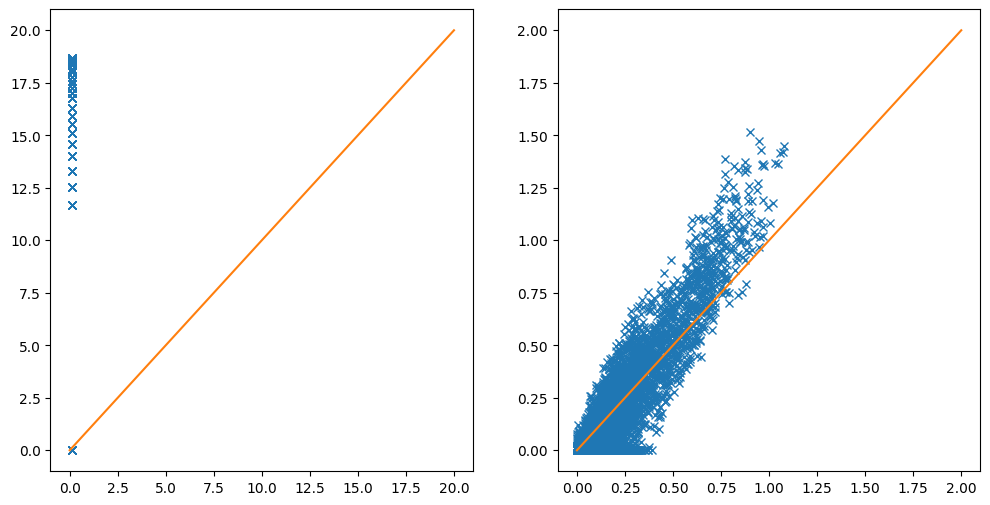


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      2   8627     0  9004   1.555D+00   9.211D+02
  F =   921.06912191379422     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -2.261  0.599E-03    31968   158.48  0.619   [Radiance 0.660 micron]
     1  -4.360  0.289E-05    31968   158.48  0.619

KeyboardInterrupt: 

In [5]:
import copy
solvers_reconstruct = copy.deepcopy(solvers)
solvers_reconstruct[.66].medium['cloud'].veff.data = carved_volume.mask.data.astype(float)*0 + .1
solvers_reconstruct[.66].medium['cloud'].reff.data = carved_volume.mask.data.astype(float)*0 + 10
solvers_reconstruct[.66].medium['cloud'].density.data = carved_volume.mask.data.astype(float)*0 + 0
iter = 20
for i in range(iter):
    print("------ Iter " + str(i) + " ------")
    solvers_reconstruct = train_density(solvers_reconstruct, i+1)
    solvers_reconstruct = train_reff(solvers_reconstruct, i+1)

------ Iter 20 ------
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.656  0.132E-01    31968   228.05  0.891   [Radiance 2.130 micron]
     1  -1.569  0.110E-01    31968   228.05  0.891   [Radiance 1.240 micron]
     1  -1.608  0.120E-01    31968   228.05  0.891   [Radiance 1.640 micron]
     1  -1.507  0.962E-02    31968   228.05  0.891   [Radiance 0.660 micron]
     2  -3.388  0.133E-01    31968   228.05  0.891   [Radiance 2.130 micron]
     2  -3.321  0.966E-02    31968   228.05  0.891   [Radiance 0.660 micron]
     2  -3.333  0.110E-01    31968   228.05  0.891   [Radiance 1.240 micron]
     2  -3.352  0.120E-01    31968   228.05  0.891   [Radiance 1.640 micron]
     3  -5.083  0.133E-01    31968   228.05  0.891   [Radiance 2.1

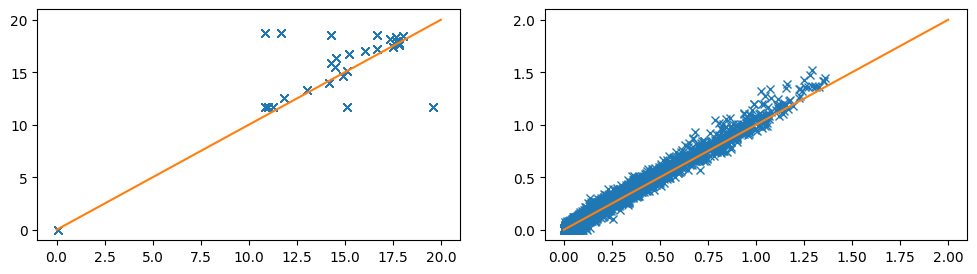


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      8  20131     0 20130   9.919D-01   4.593D+00
  F =   4.5927050228062098     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -1.607  0.120E-01    31968   228.05  0.891   [Radiance 1.640 micron]
     1  -1.506  0.964E-02    31968   228.05  0.891

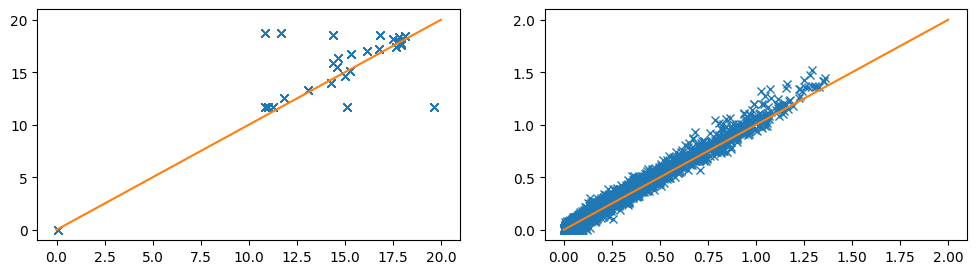

------ Iter 21 ------

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      2      1     0     0   5.967D-02   4.432D+03
  F =   4431.8890179200389     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.568  0.110E-01    31968   228.05  0.891   [Radiance 1.240 micron]
     1  -1.607  0.120E-01   

In [ ]:
for i in np.arange(20, 30):
    print("------ Iter " + str(i) + " ------")
    solvers_reconstruct = train_density(solvers_reconstruct, i+1)
    solvers_reconstruct = train_reff(solvers_reconstruct, i+1)